# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
data = pd.read_csv('../data/Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

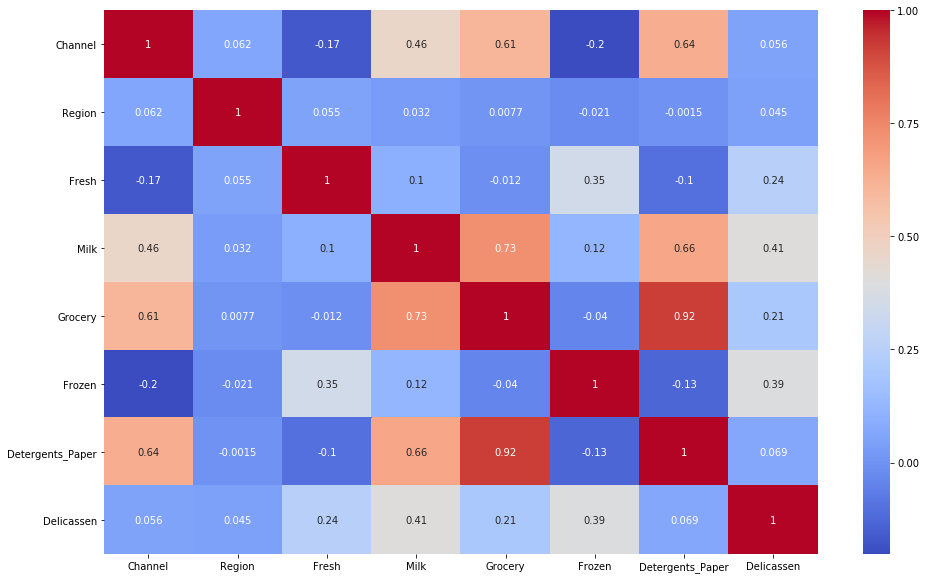

In [6]:
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), cmap='coolwarm', annot= True)

In [7]:
# The sum  of the 20% of customer that most spent
percent20_most_spent = data.iloc[:,2:].sum(axis =1).sort_values(ascending=False)[:int(data.shape[0]*0.2)].sum()

# The total spent
total_spent = data.iloc[:,2:].sum(axis=1).sum()

print((percent20_most_spent * 100)/ total_spent)
"""
The 20% of customers that most spent is the 42% of the total, 
so it doesn't satisfy the pareto principle
"""

42.90483942679298


"\nThe 20% of customers that most spent is the 42% of the total, \nso it doesn't satisfy the pareto principle\n"

In [8]:
percent80_spent_total = 0.8 * total_spent
data_spent = data.iloc[:,2:].sum(axis =1)
index = 0
while percent80_spent_total > 0:
    percent80_spent_total -= data_spent[index]
    index +=1
print(f"The percent of customers that spent the 80% of total is: {(index+1)*100/data.shape[0]:.2f}%")

The percent of customers that spent the 80% of total is: 76.14%


In [9]:
print(f"There are {(zscore(data) > 3).sum()} outliers")

There are 43 outliers


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [10]:
# Your code here
data_reduced = data[(abs(zscore(data)) < 3).all(axis=1)].copy()

In [11]:
# Your comment here
"""
We delete some outliers
"""

'\nWe delete some outliers\n'

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [12]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()

customer_scale = scaler.fit_transform(data_reduced)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [57]:
from sklearn.cluster import KMeans, DBSCAN

In [58]:
# Your code here:
cluster = KMeans(n_clusters =4).fit(customer_scale)


In [59]:
data_reduced.loc[:,'labels'] = cluster.labels_

Count the values in `labels`.

In [60]:
# Your code here:
data_reduced['labels'].value_counts()

2    149
3    121
1     73
0     71
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [61]:
# Your code here
cluster_2 =  DBSCAN(eps=0.5).fit(customer_scale)
data_reduced['labels_DBSCAN'] = cluster_2.labels_

Count the values in `labels_DBSCAN`.

In [62]:
# Your code here
data_reduced['labels_DBSCAN'].value_counts()

-1    343
 0     71
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

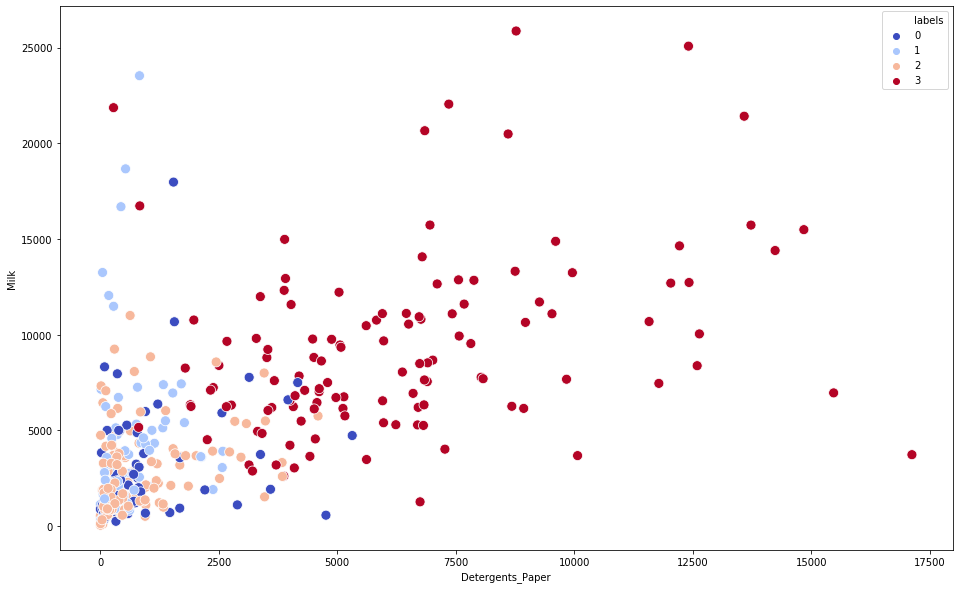

In [64]:
# Your code here:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Detergents_Paper', y = 'Milk', hue = 'labels', palette ='coolwarm', s=100 ,data=data_reduced,)


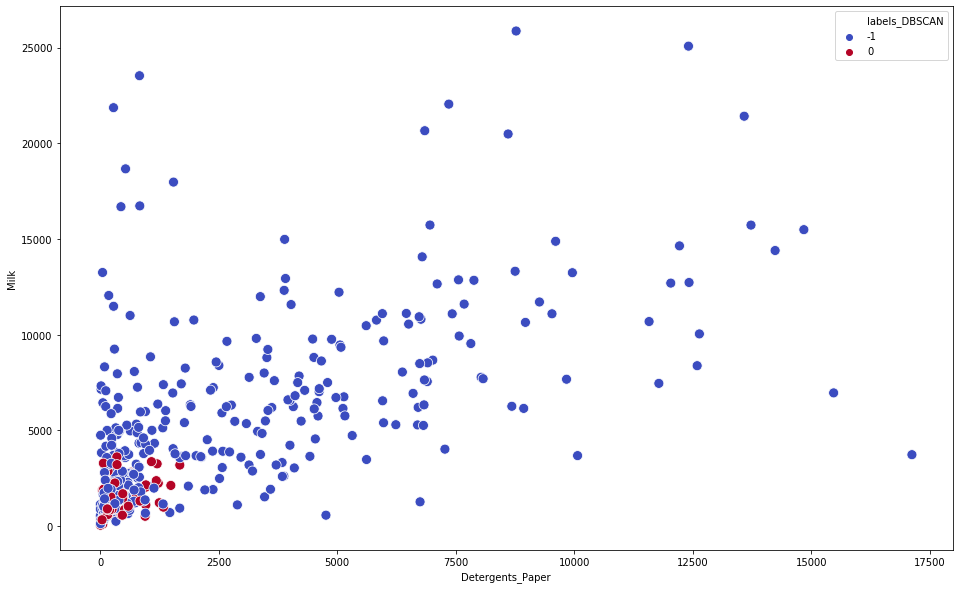

In [65]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Detergents_Paper', y = 'Milk', hue = 'labels_DBSCAN', palette ='coolwarm', s=100 ,data=data_reduced,)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

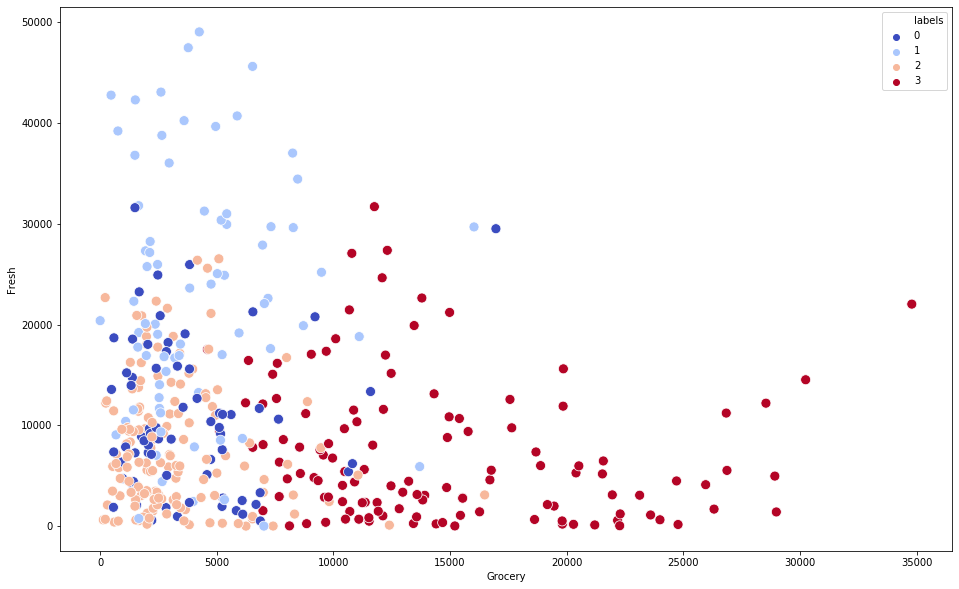

In [66]:
# Your code here:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Grocery', y = 'Fresh', hue = 'labels', palette ='coolwarm', s=100 ,data=data_reduced,)

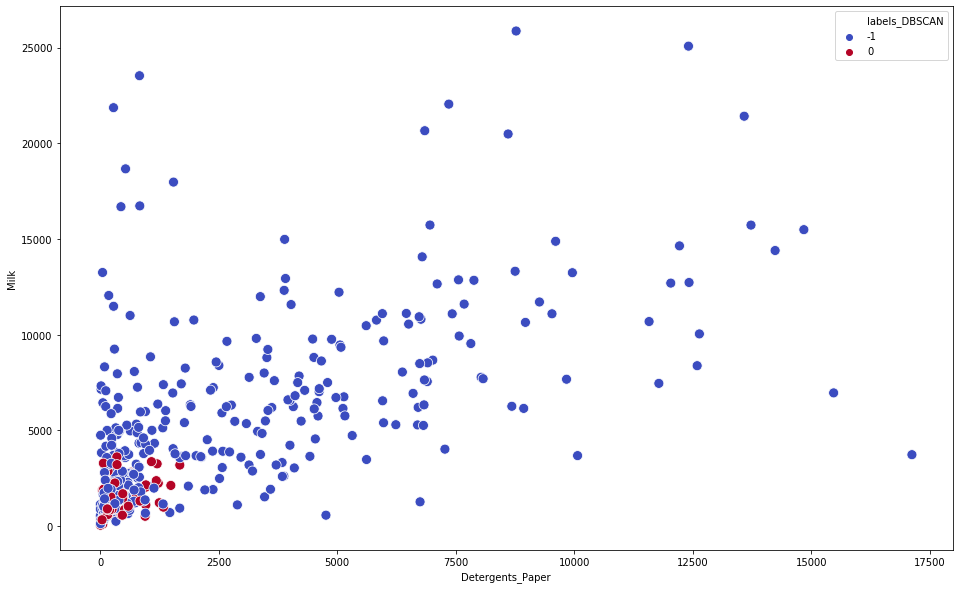

In [67]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Detergents_Paper', y = 'Milk', hue = 'labels_DBSCAN', palette ='coolwarm', s=100 ,data=data_reduced,)

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

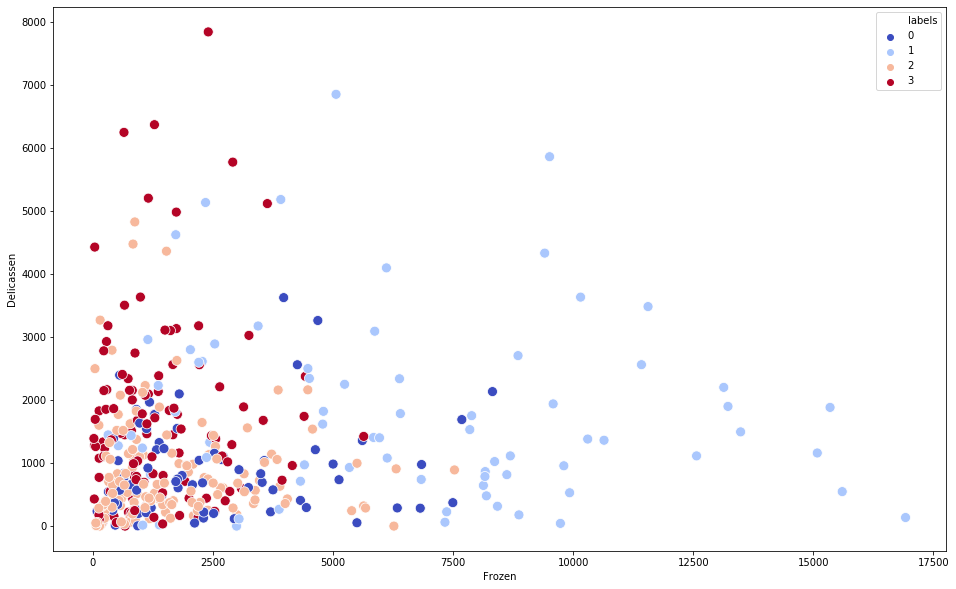

In [68]:
# Your code here:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Frozen', y = 'Delicassen', hue = 'labels', palette ='coolwarm', s=100 ,data=data_reduced,)

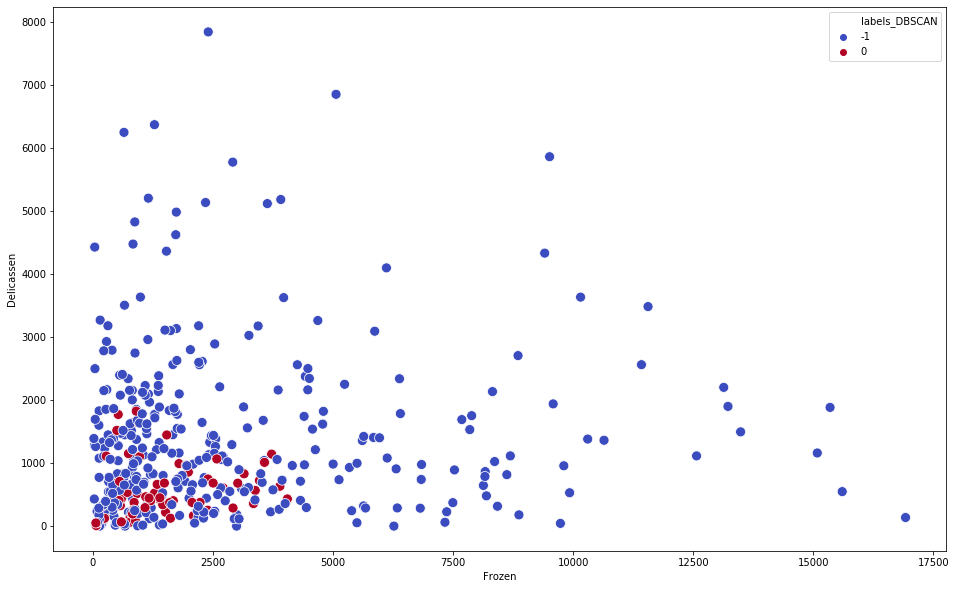

In [69]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Frozen', y = 'Delicassen', hue = 'labels_DBSCAN', palette ='coolwarm', s=100 ,data=data_reduced,)

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [70]:
# Your code here:
data_reduced.groupby('labels').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,,
0,1.070423,1.225352,10316.436620,2905.563380,3838.605634,2523.253521,935.901408,909.985915,-1.00000
1,1.068493,2.767123,22887.136986,4221.958904,4274.520548,6583.958904,643.095890,1784.178082,-1.00000
2,1.026846,2.973154,7779.543624,2534.832215,3186.335570,1599.516779,705.637584,833.718121,-0.52349
3,1.958678,2.669421,7208.991736,9295.760331,14559.247934,1302.066116,6314.462810,1598.586777,-1.00000


In [71]:
data_reduced.groupby('labels_DBSCAN').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.379009,2.45481,11641.819242,5565.478134,7822.857143,2781.938776,2779.647230,1377.119534,1.725948
0,1.000000,3.00000,6218.647887,1521.352113,1940.478873,1428.915493,410.788732,565.563380,2.000000


Which algorithm appears to perform better?

In [72]:
# Your observations here
"""
KMeans do it better
"""

'\nKMeans do it better\n'

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

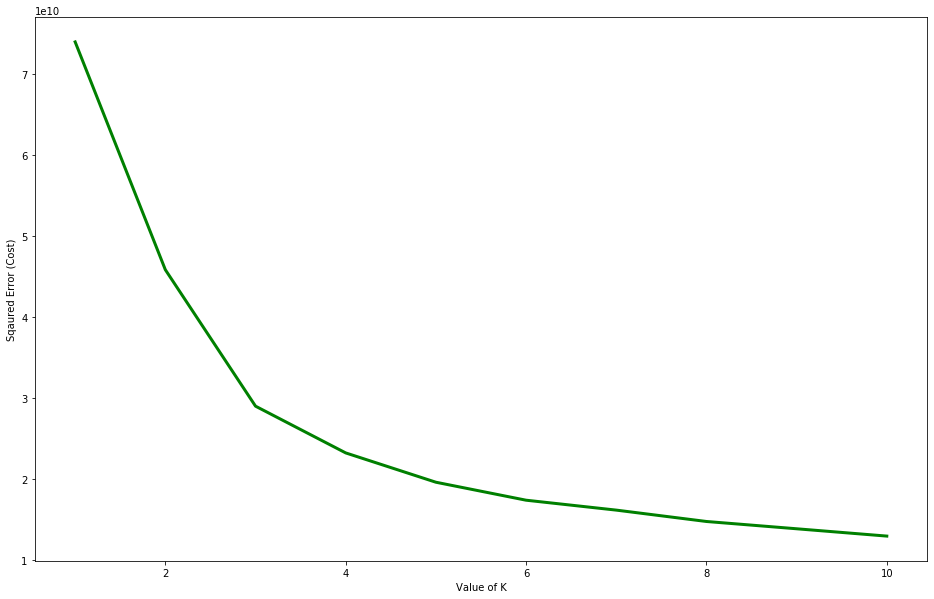

In [73]:
# Your code here
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(data_reduced) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.figure(figsize=(16,10))
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [74]:
# Your comment here
"""
Using the elbow method, I think the best value of K is 4
"""

'\nUsing the elbow method, we think the best value of K is 4\n'

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [88]:
# Your code here
cluster_2 =  DBSCAN(eps=1.5).fit(customer_scale)
data_reduced['labels_DBSCAN'] = cluster_2.labels_

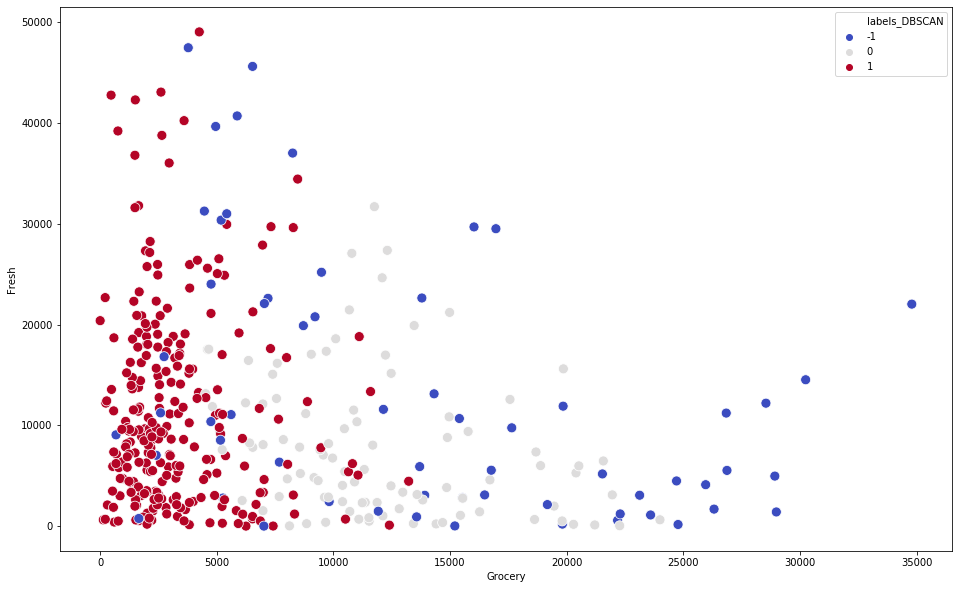

In [89]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Grocery', y = 'Fresh', hue = 'labels_DBSCAN', palette ='coolwarm', s=100 ,data=data_reduced,)